# Usage

`liana` provides different statistical methods to infer `ligand-receptor` interactions from single-cell transcriptomics data omics data using prior knowledge.
In this notebook we showcase how to use liana in its' most basic form with toy data.

<div class="alert alert-info">

**Note**
    
In Jupyter notebooks and lab, you can see the documentation for a python function by hitting `SHIFT + TAB`, hit it twice to expand the view, or by typing `?name_of_function`.

</div>  

## Loading Packages

In [22]:
import liana as li

# Only needed for visualization:
import matplotlib.pyplot as plt
from scanpy.pl import umap

# toy data
from scanpy.datasets import pbmc68k_reduced
%matplotlib inline

## Loading toy data

`liana` uses `anndata` objects with processed single-cell (*and soon spatial*) transcriptomics data, with pre-defined cell labels (identities), to predict ligand-receptor interactions among all pairs of cell identities.

To load the example data-set, simply run:

In [23]:
adata = pbmc68k_reduced()

The example single-cell data consists processed data with PBMCs cell types

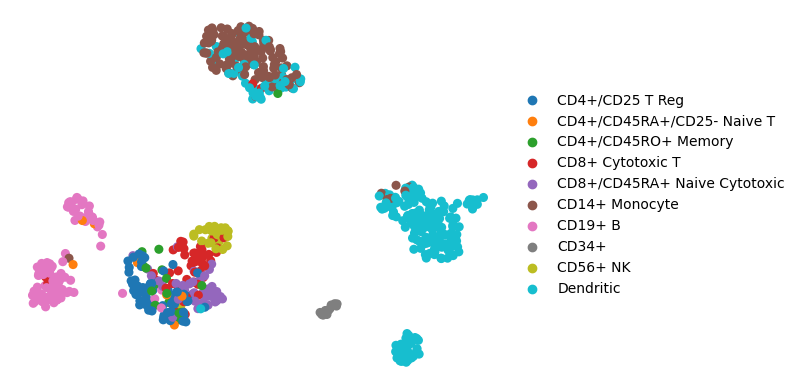

In [24]:
umap(adata, color='bulk_labels', title='', frameon=False)

## Background

In the most basic scenario, `liana` works with the log-trasformed counts matrix, in this object the normalized counts are stored in `raw`:

In [25]:
adata.raw.X

<700x765 sparse matrix of type '<class 'numpy.float32'>'
	with 174400 stored elements in Compressed Sparse Row format>

Preferably, one would use `liana` with all features (genes) for which we have enough counts, but for the sake of this tutorial we are working with a matrix pre-filtered to the variable features alone.

In the background, `liana` aggregates the counts matrix and generates statistics, typically related to cell identies.
These statistics are then utilized by each of the methods in `liana`.

### Methods

In [26]:
li.mt.show_methods()

,Method Name,Magnitude Score,Specificity Score,Reference
0,CellPhoneDB,lr_means,cellphone_pvals,"Efremova, M., Vento-Tormo, M., Teichmann, S.A...."
0,Connectome,expr_prod,scaled_weight,"Raredon, M.S.B., Yang, J., Garritano, J., Wang..."
0,log2FC,None,lr_logfc,"Dimitrov, D., Türei, D., Garrido-Rodriguez, M...."
0,NATMI,expr_prod,spec_weight,"Hou, R., Denisenko, E., Ong, H.T., Ramilowski,..."
0,SingleCellSignalR,lrscore,None,"Cabello-Aguilar, S., Alame, M., Kon-Sun-Tack, ..."
0,CellChat,lr_probs,cellchat_pvals,"Jin, S., Guerrero-Juarez, C.F., Zhang, L., Cha..."
0,Rank_Aggregate,magnitude_rank,specificity_rank,"Dimitrov, D., Türei, D., Garrido-Rodriguez, M...."
0,Geometric Mean,lr_gmeans,gmean_pvals,CellPhoneDBv2's permutation approach applied t...


Each method infers relevant ligand-receptor interactions relying on different assumptions and each method returns different ligand-receptor scores, typically a pair per method. One score corresponding to
the `magnitude` (strength) of interaction and the other reflecting how `specificity` of a given interaction to a pair cell identities.

<div class="alert alert-info">

**Note**
    
<h4> Method Class</h4>
    
Methods in liana are **callable** instances of the `Method` class. To obtain further information for each method the user can refer to the methods documentation `?method_name` or `?method.__call__`. Alternatively, users can use the `method.describe` function to get a short summary for each method.

</div>  


For example, if the user wishes to learn more about liana's `rank_aggregate` implementation, where we combine the scores of multiple methods, they could do the following: 

In [27]:
# import liana's rank_aggregate
from liana.mt import rank_aggregate

In [28]:
?rank_aggregate.__call__

Signature:
rank_aggregate.__call__(
    adata: anndata._core.anndata.AnnData,
    groupby: str,
    resource_name: str = 'consensus',
    expr_prop: float = 0.1,
    min_cells: int = 5,
    base: float = 2.718281828459045,
    aggregate_method='rra',
    return_all_lrs: bool = False,
    consensus_opts=None,
    use_raw: Union[bool, NoneType] = True,
    layer: Union[str, NoneType] = None,
    de_method='t-test',
    verbose: Union[bool, NoneType] = False,
    n_perms: int = 1000,
    seed: int = 1337,
    resource: Union[pandas.core.frame.DataFrame, NoneType] = None,
    inplace=True,
)
Docstring:
Parameters
----------
adata
    Annotated data object.
groupby
    The key of the observations grouping to consider.
resource_name
    Name of the resource to be loaded and use for ligand-receptor inference.
expr_prop
    Minimum expression proportion for the ligands/receptors (and their subunits) in the
     corresponding cell identities. Set to `0`, to return unfiltered results.
min_cells


or alternatively:

In [29]:
rank_aggregate.describe()

Rank_Aggregate returns `magnitude_rank`, `specificity_rank`, and `steady_rank`. magnitude_rank and specificity_rank represent an aggregate of the `magnitude`- and `specificity`-related scoring functions from the different methods.steady_rank (DEPRECATED) represents one scoring function from each method intended to prioritize ligand-receptor interactions in steady-state data, regardless if they represent `specificity` or `magnitude`.


#### Resources

To provide ligand-receptor predictions `liana` relies on prior-knowledge and makes use of the following ligand-receptor resources:

In [30]:
li.resource.show_resources()

['baccin2019',
 'cellcall',
 'cellchatdb',
 'cellinker',
 'cellphonedb',
 'celltalkdb',
 'connectomedb2020',
 'consensus',
 'embrace',
 'guide2pharma',
 'hpmr',
 'icellnet',
 'italk',
 'kirouac2010',
 'lrdb',
 'mouseconsensus',
 'ramilowski2015']

These were pre-generated using the [OmniPath](https://github.com/saezlab/omnipath) meta-database, but any custom resource can also be passed.
We refer the user to [OmniPath](https://github.com/saezlab/omnipath) as a useful tool to build any resource.

    
By default, `liana` uses the `consensus` resource, which is composed by multiple expert-curated ligand-receptor resources, including CellPhoneDB, CellChat, ICELLNET, connectomeDB2020, and CellTalkDB.


## Example Run

### Individual Methods

In [31]:
# import all individual methods
from liana.method import singlecellsignalr, connectome, cellphonedb, natmi, logfc, cellchat, geometric_mean

<div class="alert alert-info">

**Note**

LIANA will by default use the `.raw` attribute of AnnData. If you wish to use .X set `use_raw` to `False`, or specify a `layer`.
    
    
</div>  

In [32]:
# run cellphonedb
cellphonedb(adata, groupby='bulk_labels', expr_prop=0.1, verbose=True)

Using `.raw`!
0.94 of entities in the resource are missing from the data.
Generating ligand-receptor stats for 700 samples and 765 features


100%|██████████| 1000/1000 [00:08<00:00, 118.17it/s]


By default, liana will be run **inplace** and results will be assigned to `adata.uns['liana_res']`.
Note that the high proportion of missing entities here is expected, as we are working on the reduced dimensions data.

In [33]:
# by default, liana's output is saved in place:
adata.uns['liana_res'].head()

,ligand,ligand_complex,ligand_means,ligand_props,receptor,receptor_complex,receptor_means,receptor_props,source,target,lr_means,cellphone_pvals
0,HLA-DRA,HLA-DRA,0.625279,0.323529,CD4,CD4,0.295691,0.220588,CD4+/CD25 T Reg,CD4+/CD25 T Reg,0.460485,1.0
1,HLA-DQA2,HLA-DQA2,0.196956,0.117647,CD4,CD4,0.295691,0.220588,CD4+/CD25 T Reg,CD4+/CD25 T Reg,0.246324,1.0
2,HLA-DQA1,HLA-DQA1,0.253897,0.161765,CD4,CD4,0.295691,0.220588,CD4+/CD25 T Reg,CD4+/CD25 T Reg,0.274794,1.0
3,HLA-DRB1,HLA-DRB1,0.853603,0.382353,CD4,CD4,0.295691,0.220588,CD4+/CD25 T Reg,CD4+/CD25 T Reg,0.574647,1.0
4,HLA-DQB1,HLA-DQB1,0.401779,0.279412,CD4,CD4,0.295691,0.220588,CD4+/CD25 T Reg,CD4+/CD25 T Reg,0.348735,1.0


Here, we see that stats are provided for both ligand and receptor entities, more specifically: - `ligand` and `receptor` are typically the two entities that interact. As a reminder, CCC events are not limited to secreted signalling, but we refer to them as `ligand` and `receptor` for simplicity. 

Also, in the case of heteromeric complexes, the `ligand` and `receptor` columns represent the subunit with minimum expression, while *_complex corresponds to the actual complex, with subunits being separated by `_`.

- `source` and `target` columns represent the source/sender and target/receiver cell identity for each interaction, respectively

- `*_props`: represents the proportion of cells that express the entity. 

  By default, in CellPhoneDB and LIANA, any interactions in which either entity is not expressed in above 10% of cells per cell type is considered as a false positive,
  under the assumption that since CCC occurs between cell types, a sufficient proportion of cells within should express the genes.

- `*_means`: entity expression mean per cell type

- `lr_means`: mean ligand-receptor expression, as a measure of ligand-receptor interaction **magnitude**

- `cellphone_pvals`: permutation-based p-values, as a measure of interaction **specificity**

<div class="alert alert-info">

**Note**

    
`ligand`, `receptor`, `source`, and `target` columns are returned by every ligand-receptor method, while the rest of the columns can vary across the ligand-receptor methods, as each method infers relies on different assumptions and scoring functions, and hence each returns different ligand-receptor scores. Nevertheless, typically most methods use a pair of scoring functions - where one often corresponds to the **magnitude** (strength) of interaction and the other reflects how **specificity** of a given interaction to a pair cell identities.
    
</div>

#### Dotplot

We can now visualize the results that we just obtained.

LIANA provides some basic, but flexible plotting functionalities. Here, we will generate a dotplot of relevant ligand-receptor interactions.

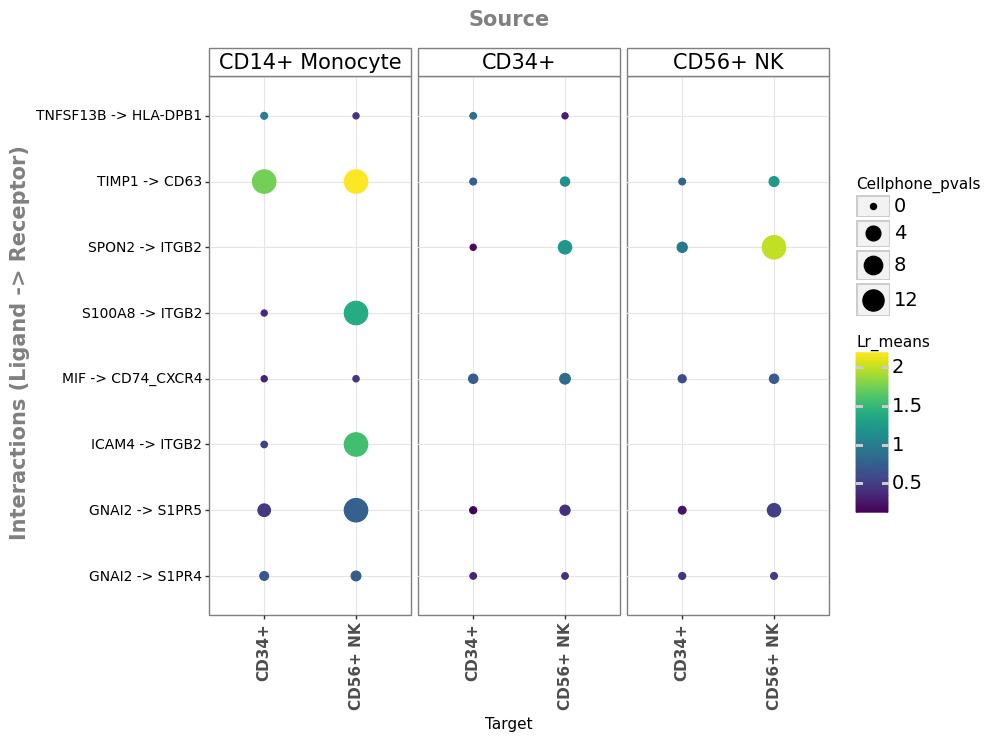

<ggplot: (8764481084898)>

In [34]:
li.pl.dotplot(adata = adata, 
              colour='lr_means',
              size='cellphone_pvals',
              inverse_size=True, # we inverse sign since we want small p-values to have large sizes
              source_labels=['CD34+', 'CD56+ NK', 'CD14+ Monocyte'],
              target_labels=['CD34+', 'CD56+ NK'],
              figure_size=(8, 7),
              # finally, since cpdbv2 suggests using a filter to FPs
              # we filter the pvals column to <= 0.05
              filterby='cellphone_pvals',
              filter_lambda=lambda x: x <= 0.05
             )

<div class="alert alert-info">
   
**Note**
    
Missing dots here would represent interactions for which the ligand and receptor are not expressed above the `expr_prop`.
</div>

### Rank Aggregate
In addition to the individual methods, LIANA also provides a consensus that integrates the predictions of individual methods.
This is done by ranking and aggregating ([RRA](https://academic.oup.com/bioinformatics/article-abstract/28/4/573/213339)) the ligand-receptor interaction predictions from all methods.

In [35]:
# Run rank_aggregate
li.mt.rank_aggregate(adata, groupby='bulk_labels', expr_prop=0.1, verbose=True)

Using `.raw`!
0.94 of entities in the resource are missing from the data.
Generating ligand-receptor stats for 700 samples and 765 features
Assuming that counts were `natural` log-normalized!


  2%|▏         | 24/1000 [00:00<00:04, 239.56it/s]

Running CellPhoneDB


100%|██████████| 1000/1000 [00:06<00:00, 156.57it/s]


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR


  2%|▏         | 24/1000 [00:00<00:04, 236.84it/s]

Running CellChat


100%|██████████| 1000/1000 [00:06<00:00, 153.69it/s]


In [36]:
adata.uns['liana_res'].head()

,source,target,ligand_complex,receptor_complex,lr_means,cellphone_pvals,expr_prod,scaled_weight,lr_logfc,spec_weight,lrscore,lr_probs,cellchat_pvals,steady_rank,specificity_rank,magnitude_rank
1092,CD14+ Monocyte,CD56+ NK,TIMP1,CD63,2.134744,0.0,4.521421,0.966945,1.435273,0.060475,0.781134,0.205616,0.000,0.000029,0.000185,0.000026
294,Dendritic,CD4+/CD45RA+/CD25- Naive T,HLA-DRA,CD4,2.566904,0.0,2.705027,0.709428,1.332656,0.063302,0.734081,0.104212,0.006,0.001185,0.006370,0.000073
1088,CD14+ Monocyte,CD56+ NK,S100A9,ITGB2,2.057126,0.0,4.198207,0.834976,1.069681,0.095159,0.774727,0.185972,0.000,0.000029,0.000185,0.000104
847,CD14+ Monocyte,CD14+ Monocyte,S100A9,ITGB2,1.982740,0.0,3.919420,0.757121,1.069747,0.088840,0.768675,0.176124,0.000,0.000029,0.000185,0.000234
297,Dendritic,CD4+/CD45RA+/CD25- Naive T,HLA-DRB1,CD4,2.406652,0.0,2.513965,0.698344,1.232695,0.058561,0.726870,0.096314,0.008,0.001185,0.006370,0.000246


In [37]:
rank_aggregate.describe()

Rank_Aggregate returns `magnitude_rank`, `specificity_rank`, and `steady_rank`. magnitude_rank and specificity_rank represent an aggregate of the `magnitude`- and `specificity`-related scoring functions from the different methods.steady_rank (DEPRECATED) represents one scoring function from each method intended to prioritize ligand-receptor interactions in steady-state data, regardless if they represent `specificity` or `magnitude`.


The remainder of the columns in this dataframe are those coming from each of the methods included in the `rank_aggregate` - i.e. see the `show_methods` to map methods to scores.

#### Dotplot

We will now plot the most 'relevant' interactions ordered to the `magnitude_rank` results from aggregated_rank.

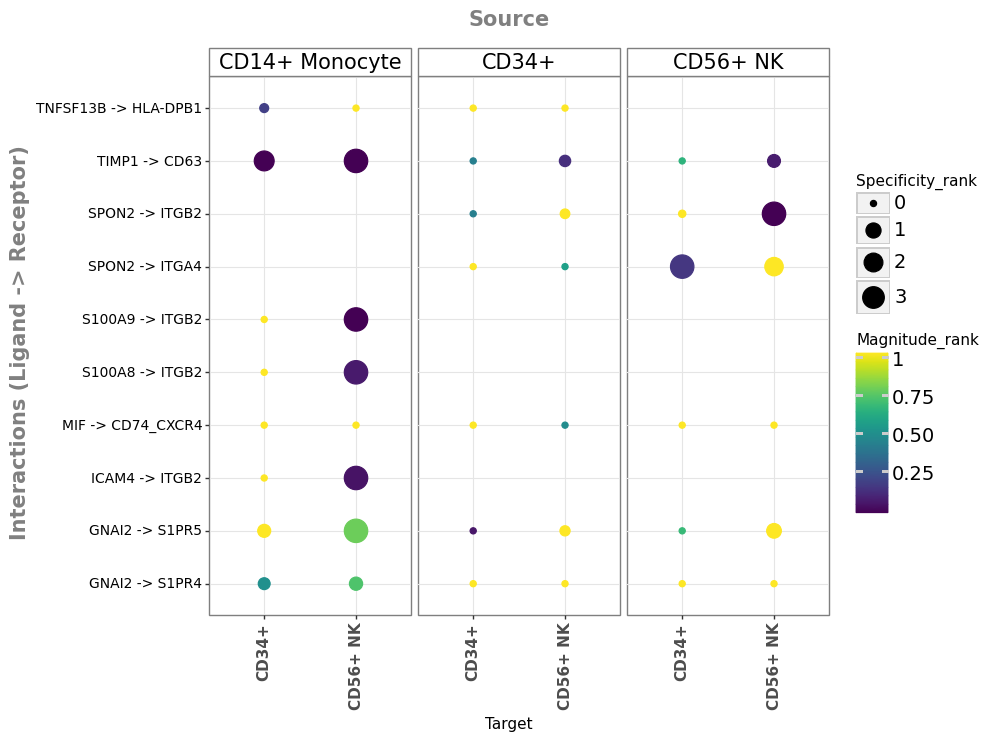

<ggplot: (8764480923582)>

In [38]:
li.pl.dotplot(adata = adata, 
              colour='magnitude_rank',
              size='specificity_rank',
              inverse_size=True,
              source_labels=['CD34+', 'CD56+ NK', 'CD14+ Monocyte'],
              target_labels=['CD34+', 'CD56+ NK'],
              top_n=10, 
              orderby='magnitude_rank',
              orderby_ascending=True,
              figure_size=(8, 7)
             )

Similarly, we can also treat the ranks provided by RRA as a probability distribution to which we can `filter` interactions
according to how robustly and highly ranked they are across the different methods.

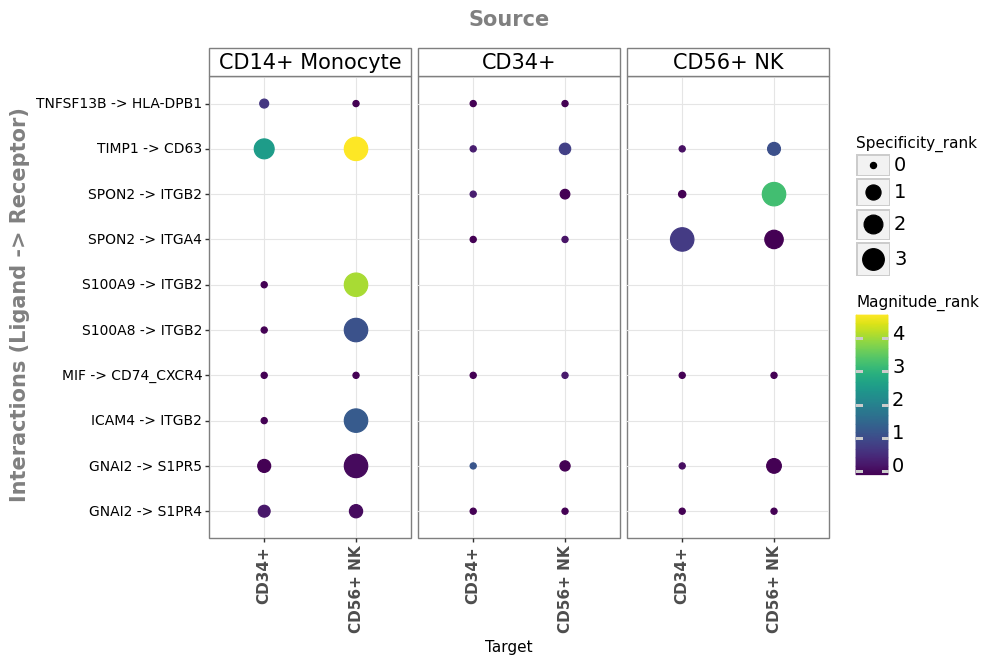

<ggplot: (8764480871611)>

In [39]:
my_plot = li.pl.dotplot(adata = adata, 
                        colour='magnitude_rank',
                        inverse_colour=True,
                        size='specificity_rank',
                        inverse_size=True,
                        source_labels=['CD34+', 'CD56+ NK', 'CD14+ Monocyte'],
                        target_labels=['CD34+', 'CD56+ NK'],
                        filterby='specificity_rank',
                        filter_lambda=lambda x: x <= 0.01,
                       )
my_plot

Finally, the plots in liana are built with `plotnine` and their aesthetics can be easily modified. For example:

In [40]:
# we import plotnine
import plotnine as p9

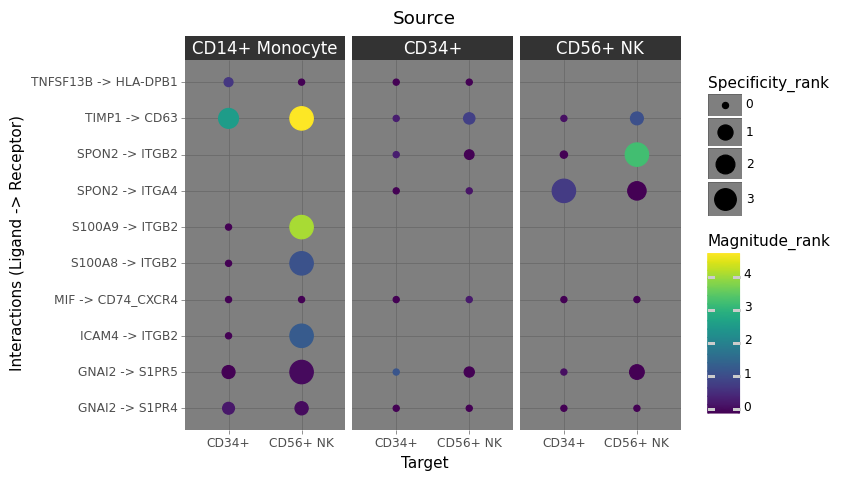

<ggplot: (8764480717297)>

In [41]:
(my_plot +
 # change theme
 p9.theme_dark() +
 # modify theme
 p9.theme(
     # adjust facet size
     strip_text=p9.element_text(size=12)
 )
)

For more plot modification options  we refer the user to `plotnine`'s tutorials
and to the following link for a quick intro: 
https://datacarpentry.org/python-ecology-lesson/07-visualization-ggplot-python/index.html.